In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Task 1

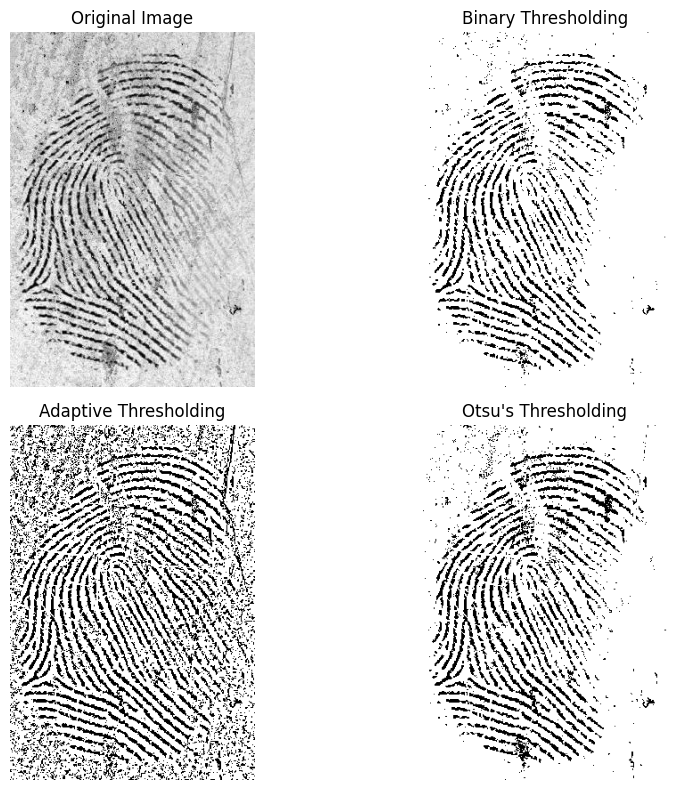

In [79]:
image_path = "images/44.jpg" 
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Binary Thresholding
_, binary_thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 10
)

# Otsu’s Thresholding
_, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

titles = ["Original Image", "Binary Thresholding", "Adaptive Thresholding", "Otsu's Thresholding"]
images = [image, binary_thresh, adaptive_thresh, otsu_thresh]

plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()


## Task 2

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_lines(image_path, canny_thresh1=30, canny_thresh2=150, hough_thresh=250):
    """
    Detects and highlights straight lines in an image using the Hough Line Transform.
    Args:
        image_path (str): Path to the input image.
        canny_thresh1 (int): Lower threshold for Canny edge detection.
        canny_thresh2 (int): Upper threshold for Canny edge detection.
        hough_thresh (int): Threshold for Hough Transform to consider a line.
    Returns:
        original_img (numpy.ndarray): Original image with lines highlighted.
    """
    image = cv2.imread(image_path)
    original_img = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Step 1: Apply Canny edge detection
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)

    # Step 2: Apply Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, hough_thresh)

    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(original_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return original_img, edges


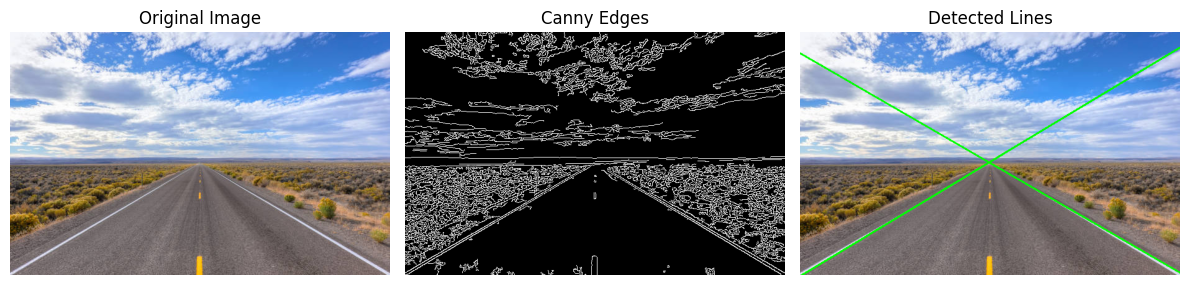

In [81]:
image_path = "images/road.jpg"


# greater than 200 leads to true lines while less than 200 leads to noisy lines.

processed_img, edges = detect_lines(image_path, canny_thresh1=30, canny_thresh2=200, hough_thresh=260)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edges")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")
plt.axis("off")

plt.tight_layout()
plt.show()


## Task 3

In [82]:
def detect_circles(image_path, dp=1.2, min_dist=50, param1=50, param2=30, min_radius=40, max_radius=70):
    """
    Detects circles in an image using the Hough Circle Transform.
    Args:
        image_path (str): Path to the input image.
        dp (float): Inverse ratio of accumulator resolution to image resolution.
        min_dist (int): Minimum distance between the centers of detected circles.
        param1 (int): Gradient threshold for edge detection (Canny's edge detection).
        param2 (int): Accumulator threshold for circle detection (higher value -> stricter detection).
        min_radius (int): Minimum circle radius.
        max_radius (int): Maximum circle radius.
    Returns:
        original_img (numpy.ndarray): Original image with circles overlaid.
        detected_circles (numpy.ndarray): Detected circles (x, y, radius).
    """
    # Load image
    image = cv2.imread(image_path)
    image = cv2.resize(image,(image.shape[1]//5,image.shape[0]//5))
    original_img = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #print(gray.shape)
    gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    detected_circles = cv2.HoughCircles(
        gray_blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=dp, 
        minDist=min_dist,
        param1=param1, 
        param2=param2, 
        minRadius=min_radius, 
        maxRadius=max_radius
    )
    print(original_img.shape)
    
    if detected_circles is not None:
        detected_circles = np.uint16(np.around(detected_circles))
        for x, y, radius in detected_circles[0, :]:
            # Draw the outer circle
            cv2.circle(original_img, (x, y), radius, (0, 255, 0), 2)
            # Draw the circle center
            cv2.circle(original_img, (x, y), 2, (0, 0, 255), 3)

    return original_img, detected_circles


(536, 453, 3)


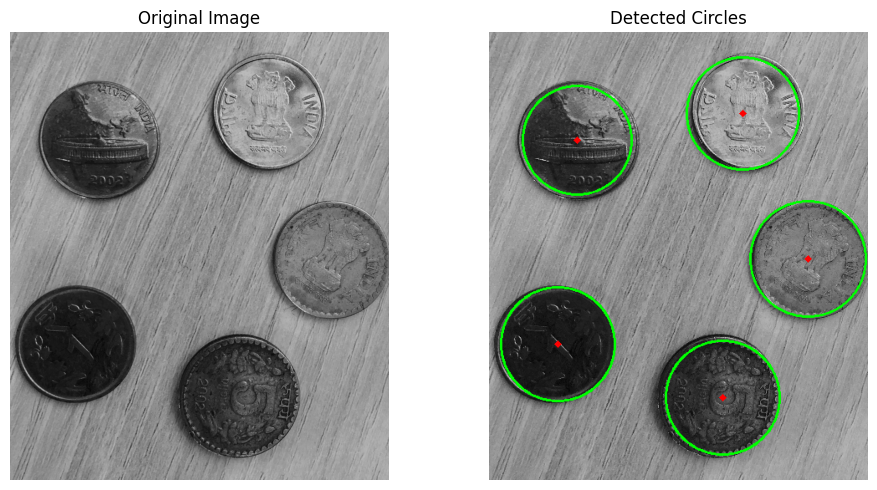

In [83]:
image_path = "images/coin-detection.jpg"  # Replace with the path to your image


processed_img, circles = detect_circles(image_path)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Circles")
plt.axis("off")

plt.tight_layout()
plt.show()

# The above set of parameters give the best result
# Low param2 (e.g., 20) detected more circles but included noise.
# High param2 (e.g., 50) reduced false positives but missed faint circles.


## Task 4

In [85]:
def harris_corner_detection(image_path, block_size=2, ksize=3, k=0.04, threshold=0.01):
    """
    Detects and marks corners in an image using Harris Corner Detection.
    
    Args:
        image_path (str): Path to the input image.
        block_size (int): Size of the neighborhood considered for corner detection.
        ksize (int): Aperture parameter for the Sobel operator.
        k (float): Harris detector free parameter (sensitivity).
        threshold (float): Relative threshold to mark corners.
        
    Returns:
        original_img (numpy.ndarray): Original image with corners marked.
        corners (numpy.ndarray): Harris corner response matrix.
    """
   
    img = cv2.imread(image_path)
    original_img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Step 1: Harris Corner Detection
    gray = np.float32(gray)  # float32 as required by Harris function
    corners = cv2.cornerHarris(gray, block_size, ksize, k)
    
    # Step 2: Dilate the corner response for better visibility
    corners = cv2.dilate(corners, None)
    
    # Step 3: Threshold to identify strong corners
    img[corners > threshold * corners.max()] = [0, 0, 255]  # Mark corners in red
    
    return img, corners


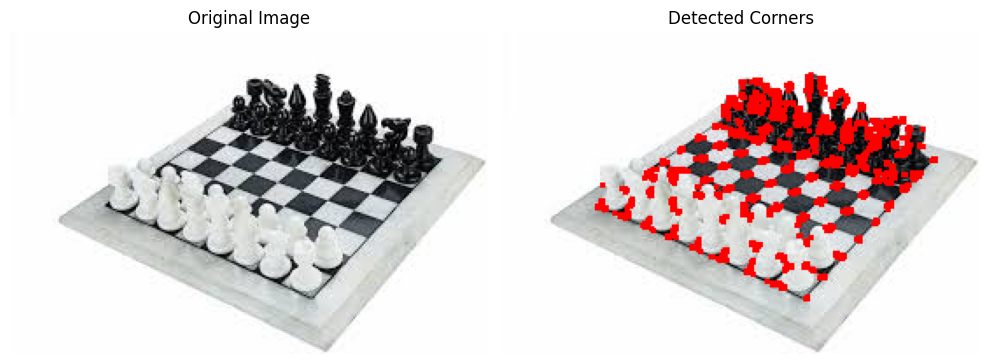

In [86]:
image_path = "images/chessboard.jpeg"


processed_img, corners = harris_corner_detection(image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Corners")
plt.axis("off")

plt.tight_layout()
plt.show()


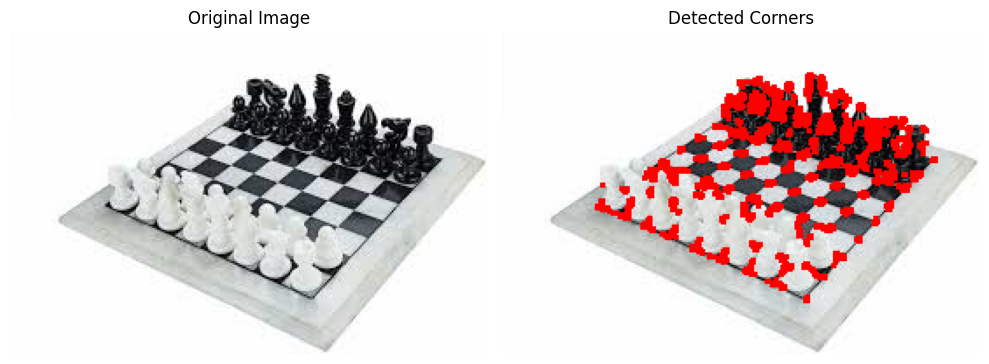

In [90]:
# changing sensistivity or k

image_path = "images/chessboard.jpeg"

processed_img, corners = harris_corner_detection(image_path, ksize = 3, k=0.02)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Corners")
plt.axis("off")

plt.tight_layout()
plt.show()
